# 🚀 Prompt Engineering: Comprehensive Testing & Optimization Guide

This notebook demonstrates advanced prompt engineering techniques for Large Language Models (LLMs), including:
- **Pointwise vs. Pairwise Testing** - Single prompt evaluation vs. comparative analysis
- **Reference-Based vs. Reference-Free Evaluation** - Ground truth comparison vs. LLM-based assessment
- **Parameter Tuning** - Temperature and Top-P effects on model outputs
- **Advanced Techniques** - Few-shot learning, Chain-of-Thought, structured outputs, and more

---

## 📊 Prompt Testing Techniques

In [1]:
"""
Import required libraries for prompt engineering experiments.
"""

from huggingface_hub import InferenceClient
from transformers import pipeline
import torch
import os
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")  # Set visualization style
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize

# Download required NLTK data (punkt for tokenization, wordnet for METEOR)
nltk.download('punkt', quiet=True)
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sp_hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
"""
Initialize HuggingFace authentication and model clients.
"""

from dotenv import load_dotenv
import re  # Import re module for regex operations (used in extract_judge_score)

load_dotenv()  # Load environment variables from .env file
hf_token = os.getenv("HF_TOKEN")  # Retrieve HuggingFace API token

# Initialize DeepSeek model client for primary experiments
# DeepSeek-R1-Distill-Qwen-32B is a reasoning model with redacted reasoning
deepseek_model_client = InferenceClient(
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B",
    token=hf_token,
    # headers={"X-Use-Cache": "false"}  # Uncomment to disable caching
)

In [3]:
def generate_response(model, system_role, user_query, temperature = 0.1, top_p = 0.1):

    response = model.chat_completion(
    messages=[{"role": "system", "content": system_role},
        {"role": "user", "content": user_query}],
    max_tokens=4000,
    temperature = temperature,
    top_p = top_p
    )

    return response.choices[0].message.content

## 📊 Pointwise vs. Pairwise Testing

**Pointwise Testing:** Evaluates a single prompt in isolation to understand its baseline performance.

**Pairwise Testing:** Compares multiple prompt variations side-by-side to identify which performs better.

**Key Difference:** Pointwise gives absolute performance; Pairwise gives relative comparison.

### 📍 Pointwise Testing

Evaluates a single prompt without comparison. Useful for:
- Initial prompt development
- Understanding baseline performance
- Testing individual prompt variations

In [4]:
"""
Pointwise Testing Example: Single Prompt Evaluation

This example demonstrates evaluating one prompt in isolation.
The model analyzes sentiment of a tweet without format constraints.
"""

# Define the system role (model's persona/instructions)
system_role = "You are an expert tweet sentiment analyzer."

# User query: sentiment analysis task without format constraints
user_query = f"""What is the sentiment expressed in the following tweet:
I like the movie but it was a bit too long."""

# Generate response using the model
output = generate_response(
    deepseek_model_client,
    system_role,
    user_query
)

# DeepSeek-R1 includes reasoning tokens; extract only the final response
# The model outputs: <reasoning>...</reasoning></think>final_answer
response = output.strip().split("</think>")[-1].strip()
response

'The sentiment of the tweet is positive. The user expresses enjoyment of the movie, which is a strong positive sentiment, despite mentioning a minor criticism about its length. The overall tone reflects a favorable opinion of the movie.'

### 🔄 Pairwise Testing

Compares multiple prompt variations to identify the most effective approach.
Useful for:
- Prompt optimization
- A/B testing different formulations
- Understanding how format constraints affect outputs

In [5]:
"""
Pairwise Testing Example: Comparing Two Prompt Variations

This example compares:
1. Prompt without format constraints (free-form response)
2. Prompt with explicit format constraints (one-word output)

This demonstrates how adding format instructions changes model behavior.
"""

system_role = "You are an expert tweet sentiment analyzer."

# Prompt 1: No format constraints - model can respond freely
user_query1 = f"""What is the sentiment expressed in the following tweet:
I like the movie but it was a bit too long."""

# Prompt 2: Explicit format constraint - must be one word from specified options
# Note: "postive" is a typo in the original prompt (should be "positive")
user_query2 = f"""What is the sentiment expressed in the following tweet.
Your response must be one word: postive, negative, or mixed.
I like the movie but it was a bit too long."""

# Store prompts in dictionary for easy iteration
prompts = {
    "Prompt 1": user_query1,  # Free-form response
    "Prompt 2": user_query2   # Constrained format
}

# Generate and compare responses from both prompts
for prompt, user_query in prompts.items():
    output = generate_response(
        deepseek_model_client,
        system_role,
        user_query
    )
    
    # Extract final response (excluding reasoning tokens)
    response = output.strip().split("</think>")[-1].strip()
    print(f"Response from {prompt}: {response}")



Response from Prompt 1: The sentiment of the tweet is **positive**. While the user acknowledges a negative aspect (the movie being too long), the overall sentiment is dominated by the positive statement that they like the movie.
Response from Prompt 2: mixed


## 🎯 Reference-Free vs. Reference-Based Testing

**Reference-Based Testing:** Compares LLM outputs against ground truth labels or expected responses.
- ✅ Objective and measurable
- ❌ Requires labeled data

**Reference-Free Testing:** Uses another LLM or heuristics to evaluate responses without predefined answers.
- ✅ No labels needed, flexible
- ❌ Subjective, may be inconsistent

### ✅ Reference-Based Testing

Evaluates responses against known ground truth labels.
Perfect for tasks with clear correct answers (classification, fact-checking).

In [6]:
"""
Reference-Based Testing Example: Ground Truth Comparison

This example evaluates the model's response against a known correct answer.
The target label "mixed" represents the ground truth for this tweet.
"""

# Ground truth label (what we expect the model to predict)
target_label = "mixed"

system_role = "You are an expert tweet sentiment analyzer."
user_query = f"""What is the sentiment expressed in the following tweet.
Your response must be one word: postive, negative, or mixed.
I like the movie but it was a bit too long."""

# Generate model response
output = generate_response(
    deepseek_model_client,
    system_role,
    user_query
)

# Extract final response
response = output.strip().split("</think>")[-1].strip()
print(response)

# Compare against ground truth
if response == target_label:
    print("✅ Correct")
else:
    print("❌ Incorrect")

mixed
✅ Correct


### 🤖 Reference-Free Testing

Uses another LLM (judge model) to evaluate responses without ground truth.
Useful when labels are unavailable or evaluation criteria are subjective.

In [7]:
"""
Reference-Free Testing Example: LLM-as-a-Judge

This example uses a separate LLM (Llama-3.3-70B) to evaluate the response
from the primary model (DeepSeek) without requiring ground truth labels.

This is a common pattern in production systems where human evaluation
is expensive or labels are unavailable.
"""

# Initialize a different model to act as a judge/evaluator
# Using Llama-3.3-70B-Instruct as the judge model
llama_model_client = InferenceClient(
    "meta-llama/Llama-3.3-70B-Instruct",
    token=hf_token
)

# Judge model's role: evaluate other LLM responses
system_role = "You are an expert LLM response evaluator."

# Judge prompt: asks the judge model to evaluate accuracy
# Note: Uses variables from previous cell (user_query, response)
user_query = f"""Given the following input to an LLM: {user_query},
and the following response {response}. Do you think the response is accurate?"""

# Generate judge's evaluation
output = generate_response(
    llama_model_client,
    system_role,
    user_query
)
output

'Yes. \n\nThe tweet expresses both a positive sentiment ("I like the movie") and a negative sentiment ("it was a bit too long"), which justifies the response "mixed".'

## ⚙️ Factors Affecting Prompt Response

Several factors influence LLM outputs beyond just the prompt text:
1. **System Instructions** - Role definition and persona
2. **Temperature** - Controls randomness in sampling
3. **Top-P** - Nucleus sampling parameter for diversity control

### 👤 System Instructions

The system role/persona significantly influences output style, format, and behavior.
More specific instructions lead to more constrained, predictable outputs.

In [8]:
"""
System Instructions Example 1: Vague Role Definition

This example uses a basic system role without format constraints.
The model may provide verbose or free-form responses.
"""

# Basic system role - no format constraints
system_role = "You are an expert tweet sentiment analyzer."

# User query with format instruction (note: typo "postive" instead of "positive")
user_query = f"""What is the sentiment expressed in the following tweet.
Your response must be negative postive, negative, or mixed.
I like the movie but it was a bit too long."""

output = generate_response(
    deepseek_model_client,
    system_role,
    user_query
)

response = output.strip().split("</think>")[-1].strip()
response

'The sentiment expressed in the tweet is mixed. The user likes the movie (positive) but finds it too long (negative), indicating a combination of both sentiments. \n\nAnswer: Mixed'

In [9]:
"""
System Instructions Example 2: Specific Format Constraint

This example adds format constraint to the system role itself.
Combining system-level and user-level constraints for stronger enforcement.
"""

# Enhanced system role with explicit format constraint
system_role = "You are an expert tweet sentiment analyzer. You respond in a single word."

# Same user query as before
user_query = f"""What is the sentiment expressed in the following tweet.
Your response must be negative postive, negative, or mixed.
I like the movie but it was a bit too long."""

output = generate_response(
    deepseek_model_client,
    system_role,
    user_query
)

response = output.strip().split("</think>")[-1].strip()
response

'mixed'

### 🌡️ Temperature Settings

Temperature controls randomness in token sampling:
- **Low (0.0-0.3):** Deterministic, consistent outputs (best for factual tasks)
- **Medium (0.5-0.7):** Balanced creativity and consistency
- **High (0.8-1.0+):** Creative, varied outputs (best for creative writing)

In [10]:
"""
Temperature Example 1: Low Temperature (Deterministic)

Temperature = 0.0 makes the model choose the most likely token at each step.
This produces consistent, deterministic outputs - same prompt → same response.
Best for: Factual tasks, classification, when consistency is critical.
"""

system_prompt = "You are an expert tweet sentiment analyzer."
user_query = f"""What is the sentiment expressed in the following tweet:
I liked the movie but it was a bit too long."""

# Temperature = 0: Most deterministic, always picks highest probability token
output = generate_response(
    deepseek_model_client,
    system_prompt,
    user_query,
    temperature=0  # Deterministic sampling
)

response = output.strip().split("</think>")[-1].strip()
response

'The sentiment expressed in the tweet is mixed. The user liked the movie, indicating a positive sentiment, but also found it too long, which introduces a negative aspect. Therefore, the overall sentiment is a combination of both positive and negative elements.'

In [11]:
"""
Temperature Example 2: High Temperature (Creative)

Temperature = 0.8 introduces randomness, allowing less likely tokens to be selected.
This produces more varied, creative outputs - same prompt → different responses.
Best for: Creative writing, brainstorming, when diversity is desired.
"""

# Same prompt as before, but with higher temperature
output = generate_response(
    deepseek_model_client,
    system_prompt,
    user_query,
    temperature=0.8  # Higher randomness, more creative
)

response = output.strip().split("</think>")[-1].strip()
response

'The sentiment of the tweet is mixed. The user expresses a positive sentiment by liking the movie but also mentions a negative aspect regarding its length. Therefore, the overall sentiment is mixed.'

### 🎲 The Effect of Top-P (Nucleus Sampling)

Top-P limits token selection to the top-p probability mass:
- **Low (0.1-0.3):** Very focused, narrow vocabulary (precise outputs)
- **Medium (0.5-0.7):** Balanced diversity
- **High (0.8-0.95):** Diverse vocabulary, creative responses

In [12]:
"""
Top-P Example 1: Low Top-P (Focused Sampling)

Top-P = 0.1 means only tokens in the top 10% probability mass are considered.
This creates very focused, predictable outputs with limited vocabulary diversity.
Works well with temperature = 0.5 for balanced control.
"""

system_prompt = "You are an expert tweet sentiment analyzer."
user_query = f"""What is the sentiment expressed in the following tweet:
I liked the movie but it was a bit too long."""

# Low top_p: Only considers tokens in top 10% probability mass
output = generate_response(
    deepseek_model_client,
    system_prompt,
    user_query,
    temperature=0.5,  # Moderate randomness
    top_p=0.1         # Very focused vocabulary
)

response = output.strip().split("</think>")[-1].strip()
response


'The sentiment of the tweet is mixed. The user expresses a positive sentiment by stating they liked the movie but also includes a negative aspect by mentioning that it was a bit too long. Therefore, the overall sentiment combines both positive and negative elements.'

In [13]:
"""
Top-P Example 2: High Top-P (Diverse Sampling)

Top-P = 0.9 means tokens in the top 90% probability mass are considered.
This allows for more diverse vocabulary and creative word choices.
Compare with previous cell to see the difference in output style.
"""

# Same prompt, but with higher top_p for more diversity
output = generate_response(
    deepseek_model_client,
    system_prompt,
    user_query,
    temperature=0.5,  # Same temperature
    top_p=0.9         # Much broader vocabulary selection
)

response = output.strip().split("</think>")[-1].strip()
response

'The sentiment of the tweet "I liked the movie but it was a bit too long" is mixed. This classification is because the tweet contains both positive and negative elements. The user expresses enjoyment of the movie, indicating a positive sentiment, but also criticizes its length, which introduces a negative aspect. Therefore, the overall sentiment is mixed, reflecting both appreciation and criticism.'

### ⚖️ LLM As a Judge

Using a separate LLM to evaluate responses from another model.
This enables scalable evaluation without human annotators.
The judge provides structured feedback with ratings and rationale.

In [14]:
system_role = "You are an expert in Question Answering. Answer like a human."
content="""I am building a machine learning model to predict customer churn for a subscription-based service.
Can you explain the key steps involved in building such a model, including data preparation,
feature engineering, model selection, and evaluation? """
user_query = f"""Generate a answer for the following question in 1000 characters:\n{content}"""
output = generate_response(deepseek_model_client,
                           system_role,
                           user_query)

## only retrieve the response not the thought process
response1 = output.strip().split("</think>")[-1].strip()
response1

"Building a machine learning model to predict customer churn involves several key steps, each with its own considerations and challenges. Here's a structured approach to guide you through the process:\n\n### 1. Data Preparation\n- **Data Collection**: Gather relevant data from company databases or CRM systems, including subscription details, payment history, usage patterns, demographics, and support interactions.\n- **Data Cleaning**: Address missing values, duplicates, and outliers. Use imputation techniques for missing data and remove duplicates to avoid bias.\n- **Handling Categorical Variables**: Convert categorical variables using one-hot encoding for nominal data and label encoding for ordinal data.\n\n### 2. Feature Engineering\n- **Feature Creation**: Develop new features from existing data, such as average monthly usage or support tickets filed, to capture hidden patterns.\n- **Data Splitting**: Split the dataset into training, validation, and test sets. Consider stratified sa

In [15]:
def extract_judge_score(answer: str, split_str: str = "Total rating:") -> int:
    try:
        if split_str in answer:
            rating = answer.split(split_str)[1]
        else:
            rating = answer
        digit_groups = [el.strip() for el in re.findall(r"\d+(?:\.\d+)?", rating)]
        return float(digit_groups[0])
    except Exception as e:
        print(e)
        return None

IMPROVED_JUDGE_PROMPT = """
You will be given a user_question and system_answer couple.
Your task is to provide a 'total rating' scoring how well the system_answer answers the user concerns expressed in the user_question.
Give your answer on a scale of 1 to 4, where 1 means that the system_answer is not helpful at all, and 4 means that the system_answer completely and helpfully addresses the user_question.

Here is the scale you should use to build your answer:
1: The system_answer is terrible: completely irrelevant to the question asked, or very partial
2: The system_answer is mostly not helpful: misses some key aspects of the question
3: The system_answer is mostly helpful: provides support, but still could be improved
4: The system_answer is excellent: relevant, direct, detailed, and addresses all the concerns raised in the question

Provide your feedback as follows:

Feedback:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 4)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here are the question and answer.

Question: {question}
Answer: {answer}

Provide your feedback. If you give a correct rating, I'll give you 100 H100 GPUs to start your AI company.
Feedback:::
Evaluation: """




In [16]:
# -----------------------------
# 6. Judge the Answer
# -----------------------------
judge_prompt = IMPROVED_JUDGE_PROMPT.format(
    question=content,
    answer=response1
)

# judge_prompt

In [17]:
system_role = "You are an expert judge response evaulator."
user_query = judge_prompt


judge_output = generate_response(llama_model_client,
               system_role,
               user_query)
judge_output

'Feedback:::\nEvaluation: The system_answer provides a comprehensive and structured approach to building a machine learning model for predicting customer churn. It covers all the key steps involved, including data preparation, feature engineering, model selection, and evaluation, as well as additional considerations such as class imbalance and feature scaling. The answer is detailed, direct, and relevant to the question asked, addressing all the concerns raised. The use of specific techniques and algorithms, such as one-hot encoding, stratified sampling, and SHAP values, demonstrates a high level of expertise and provides actionable advice for the user. Overall, the system_answer is excellent, providing a clear and thorough guide for building an effective churn prediction model.\n\nTotal rating: 4'

In [18]:
judge_score = extract_judge_score(judge_output)

print("Judge Feedback:")
print(judge_output)
print("-" * 50)

print(f"Final LLM-as-a-Judge Score: {judge_score}")


Judge Feedback:
Feedback:::
Evaluation: The system_answer provides a comprehensive and structured approach to building a machine learning model for predicting customer churn. It covers all the key steps involved, including data preparation, feature engineering, model selection, and evaluation, as well as additional considerations such as class imbalance and feature scaling. The answer is detailed, direct, and relevant to the question asked, addressing all the concerns raised. The use of specific techniques and algorithms, such as one-hot encoding, stratified sampling, and SHAP values, demonstrates a high level of expertise and provides actionable advice for the user. Overall, the system_answer is excellent, providing a clear and thorough guide for building an effective churn prediction model.

Total rating: 4
--------------------------------------------------
Final LLM-as-a-Judge Score: 4.0


## 📚 Advanced Prompting Techniques

### 🎓 Few-Shot Learning

Demonstrates in-context learning by providing examples before the target task.
Few-shot prompts improve accuracy by clarifying expected format and task boundaries.


In [19]:
"""
Few-Shot Learning: Zero-Shot vs. Few-Shot Comparison

This example demonstrates the difference between:
1. Zero-Shot: No examples provided, model relies on pre-training
2. Few-Shot: Examples provided in-context to guide model behavior

Few-shot learning often improves accuracy by:
- Clarifying the expected output format
- Demonstrating task boundaries
- Providing domain-specific patterns
"""

# ============================================================================
# Zero-Shot Example: No examples provided
# ============================================================================
zero_shot_prompt = """Classify the sentiment of the following review as positive, negative, or neutral:
Review: The product arrived damaged and the customer service was unhelpful."""

print("=== ZERO-SHOT ===")
output_zero = generate_response(
    deepseek_model_client, 
    "You are a sentiment classifier.", 
    zero_shot_prompt,
    temperature=0.1
)
response_zero = output_zero.strip().split("</think>")[-1].strip()
print(f"Response: {response_zero}\n")

# ============================================================================
# Few-Shot Example: Examples provided in the prompt
# ============================================================================
few_shot_prompt = """Classify the sentiment of the following review as positive, negative, or neutral.

Examples:
Review: I love this product! It works perfectly.
Sentiment: positive

Review: This is terrible quality, very disappointed.
Sentiment: negative

Review: The product is okay, nothing special.
Sentiment: neutral

Now classify this review:
Review: The product arrived damaged and the customer service was unhelpful.
Sentiment:"""

print("=== FEW-SHOT ===")
output_few = generate_response(
    deepseek_model_client,
    "You are a sentiment classifier.",
    few_shot_prompt,
    temperature=0.1
)
response_few = output_few.strip().split("</think>")[-1].strip()
print(f"Response: {response_few}")


=== ZERO-SHOT ===
Response: The sentiment of the review is negative. The customer expresses dissatisfaction with both the damaged product and the unhelpful customer service.

=== FEW-SHOT ===
Response: The sentiment of the review is negative because it highlights two negative experiences: the product arriving damaged and unhelpful customer service, without any positive elements.

Sentiment: negative


### 🧠 Chain-of-Thought (CoT) Prompting

Encourages step-by-step reasoning for complex problems.
CoT improves accuracy on multi-step reasoning tasks by making intermediate steps explicit.


In [20]:
"""
Chain-of-Thought (CoT) Prompting: Standard vs. CoT Comparison

This example compares:
1. Standard Prompt: Direct question without explicit reasoning steps
2. Chain-of-Thought Prompt: Explicitly requests step-by-step reasoning

CoT is particularly effective for:
- Multi-step math problems
- Logical reasoning tasks
- Complex problem-solving
"""

# Math problem to solve
math_problem = "A store has 15 apples. They sell 6 apples in the morning and 4 apples in the afternoon. How many apples are left?"

# ============================================================================
# Standard Prompt: No explicit reasoning steps requested
# ============================================================================
standard_prompt = f"""Solve this math problem:
{math_problem}"""

print("=== STANDARD PROMPT ===")
output_standard = generate_response(
    deepseek_model_client,
    "You are a math problem solver.",
    standard_prompt,
    temperature=0.1
)
response_standard = output_standard.strip().split("</think>")[-1].strip()
print(f"Response: {response_standard}\n")

# ============================================================================
# Chain-of-Thought Prompt: Explicitly requests step-by-step reasoning
# ============================================================================
cot_prompt = f"""Solve this math problem step by step:
{math_problem}

Let's think through this step by step:
1. Start with the initial number of apples
2. Subtract the apples sold in the morning
3. Subtract the apples sold in the afternoon
4. State the final answer"""

print("=== CHAIN-OF-THOUGHT PROMPT ===")
output_cot = generate_response(
    deepseek_model_client,
    "You are a math problem solver. Show your reasoning step by step.",
    cot_prompt,
    temperature=0.1
)
response_cot = output_cot.strip().split("</think>")[-1].strip()
print(f"Response: {response_cot}")


=== STANDARD PROMPT ===
Response: **Solution:**

1. **Initial number of apples:**  
   The store starts with **15 apples**.

2. **Apples sold during the day:**  
   - **Morning sales:** 6 apples  
   - **Afternoon sales:** 4 apples  
   - **Total apples sold:** \(6 + 4 = 10\) apples

3. **Calculating the remaining apples:**  
   Subtract the total apples sold from the initial number of apples:  
   \[
   15 \text{ apples} - 10 \text{ apples} = 5 \text{ apples}
   \]

**Final Answer:**  
\[
\boxed{5}
\]

=== CHAIN-OF-THOUGHT PROMPT ===
Response: Let's solve the problem step by step:

**Problem Statement:**
A store has 15 apples. They sell 6 apples in the morning and 4 apples in the afternoon. How many apples are left?

**Solution:**

1. **Initial Number of Apples:**
   \[
   \text{Total apples} = 15
   \]

2. **Apples Sold in the Morning:**
   \[
   \text{Apples sold in the morning} = 6
   \]
   
   **Apples Remaining After Morning Sales:**
   \[
   15 - 6 = 9
   \]

3. **Apples Sold in

### 📋 Output Format Control (Structured Outputs)

Demonstrates how to generate structured outputs (JSON, formatted text) by
explicitly instructing the model on the desired format.


In [21]:
"""
Output Format Control: JSON Structured Output

Demonstrates how to generate structured JSON outputs by:
1. Explicitly specifying the JSON schema in the prompt
2. Instructing the model to return valid JSON
3. Parsing and validating the output

This technique enables programmatic extraction of information from LLM responses.
"""

# JSON extraction prompt with explicit schema
json_prompt = """Extract information from the following text and return it as JSON:
Text: "John Smith is a 35-year-old software engineer working at Google in Mountain View, California."

Return the information in this JSON format:
{
  "name": "...",
  "age": ...,
  "occupation": "...",
  "company": "...",
  "location": "..."
}"""

print("=== JSON FORMAT OUTPUT ===")
output_json = generate_response(
    deepseek_model_client,
    "You are a data extraction assistant. Always return valid JSON.",
    json_prompt,
    temperature=0.1  # Low temperature for consistent format
)
response_json = output_json.strip().split("</think>")[-1].strip()
print(response_json)

# ============================================================================
# Validate JSON Format
# ============================================================================
import json

try:
    # Extract JSON from response if it's wrapped in markdown code blocks
    json_str = response_json
    
    # Handle markdown code block formatting (```json ... ```)
    if "```json" in json_str:
        json_str = json_str.split("```json")[1].split("```")[0].strip()
    elif "```" in json_str:
        # Handle generic code blocks
        json_str = json_str.split("```")[1].split("```")[0].strip()
    
    # Parse JSON to verify it's valid
    parsed = json.loads(json_str)
    print("\n✓ Valid JSON parsed successfully!")
    print(f"Extracted data: {parsed}")
except Exception as e:
    print(f"\n✗ JSON parsing failed: {e}")


=== JSON FORMAT OUTPUT ===
```json
{
  "name": "John Smith",
  "age": 35,
  "occupation": "software engineer",
  "company": "Google",
  "location": "Mountain View, California"
}
```

✓ Valid JSON parsed successfully!
Extracted data: {'name': 'John Smith', 'age': 35, 'occupation': 'software engineer', 'company': 'Google', 'location': 'Mountain View, California'}


### 📝 Prompt Templates and Best Practices

Demonstrates different prompt template patterns for consistent, reusable prompts.
Templates help standardize prompt structure across different tasks.


In [22]:
"""
Prompt Templates: Reusable Prompt Patterns

This example demonstrates three common prompt template patterns:
1. Role-Based: Emphasizes the model's role/persona
2. Instruction-Based: Separates instructions, context, and question
3. Conversational: Natural conversation flow

Templates help:
- Standardize prompt structure
- Improve consistency
- Enable easy customization
"""

# ============================================================================
# Template 1: Role-Based Template
# ============================================================================
# Emphasizes the model's role and task
role_template = """Role: {role}
Task: {task}
Input: {input}
Output:"""

# ============================================================================
# Template 2: Instruction-Based Template
# ============================================================================
# Separates instructions, context, and question for clarity
instruction_template = """Instructions: {instructions}

Context: {context}

Question: {question}

Answer:"""

# ============================================================================
# Template 3: Conversational Template
# ============================================================================
# Natural conversation flow
conversational_template = """You are {role}. The user asks: {question}

Your response:"""

# ============================================================================
# Example Usage: Role-Based Template
# ============================================================================
print("=== ROLE-BASED TEMPLATE ===")
prompt1 = role_template.format(
    role="expert data analyst",
    task="analyze the sentiment",
    input="The new product launch was a huge success!"
)
output1 = generate_response(deepseek_model_client, "", prompt1, temperature=0.1)
print(f"Template: {prompt1[:100]}...")
print(f"Response: {output1.strip().split('</think>')[-1].strip()[:200]}...\n")

# ============================================================================
# Example Usage: Instruction-Based Template
# ============================================================================
print("=== INSTRUCTION-BASED TEMPLATE ===")
prompt2 = instruction_template.format(
    instructions="Provide a concise summary in 2-3 sentences",
    context="AI is transforming healthcare through diagnostic tools and personalized treatment plans.",
    question="What is the main impact of AI in healthcare?"
)
output2 = generate_response(deepseek_model_client, "", prompt2, temperature=0.1)
print(f"Template: {prompt2[:100]}...")
print(f"Response: {output2.strip().split('</think>')[-1].strip()[:200]}...")


=== ROLE-BASED TEMPLATE ===
Template: Role: expert data analyst
Task: analyze the sentiment
Input: The new product launch was a huge succe...
Response: The sentiment of the sentence "The new product launch was a huge success!" is positive. The use of the word "success" and the emphasis with "huge" clearly indicate a positive sentiment....

=== INSTRUCTION-BASED TEMPLATE ===
Template: Instructions: Provide a concise summary in 2-3 sentences

Context: AI is transforming healthcare thr...
Response: The main impact of AI in healthcare is revolutionizing diagnostics and personalizing treatment plans. AI enhances the accuracy and speed of disease detection through advanced diagnostic tools and tail...


### 🔗 Prompt Chaining (Multi-Step Reasoning)

Demonstrates multi-step workflows where each step builds on previous outputs.
Useful for complex tasks requiring decomposition (research, analysis, summarization).


In [23]:
"""
Prompt Chaining: Multi-Step Reasoning Workflow

This example demonstrates a 3-step pipeline:
1. Extraction: Extract key topics from text
2. Analysis: Analyze relationships between topics
3. Summarization: Generate final summary

Each step uses the output from the previous step, creating a reasoning chain.
This technique is useful for complex tasks that benefit from decomposition.
"""

# ============================================================================
# Step 1: Extract Key Information
# ============================================================================
step1_prompt = """Extract the main topics from this text:
Text: "Machine learning models require large datasets for training. Deep learning, a subset of ML, uses neural networks. Both require significant computational resources."

List the main topics:"""

print("=== STEP 1: EXTRACTION ===")
step1_output = generate_response(
    deepseek_model_client,
    "You are an information extraction assistant.",
    step1_prompt,
    temperature=0.1
)
step1_result = step1_output.strip().split("</think>")[-1].strip()
print(f"Extracted topics: {step1_result}\n")

# ============================================================================
# Step 2: Analyze Extracted Information
# ============================================================================
# Uses output from Step 1 as input
step2_prompt = f"""Based on these topics: {step1_result}

Analyze the relationship between these topics and provide insights."""

print("=== STEP 2: ANALYSIS ===")
step2_output = generate_response(
    deepseek_model_client,
    "You are an analytical assistant.",
    step2_prompt,
    temperature=0.1
)
step2_result = step2_output.strip().split("</think>")[-1].strip()
print(f"Analysis: {step2_result}\n")

# ============================================================================
# Step 3: Generate Final Summary
# ============================================================================
# Uses outputs from both Step 1 and Step 2
step3_prompt = f"""Based on the topics and analysis:
Topics: {step1_result}
Analysis: {step2_result}

Generate a concise summary (2-3 sentences):"""

print("=== STEP 3: SUMMARIZATION ===")
step3_output = generate_response(
    deepseek_model_client,
    "You are a summarization assistant.",
    step3_prompt,
    temperature=0.1
)
step3_result = step3_output.strip().split("</think>")[-1].strip()
print(f"Final Summary: {step3_result}")


=== STEP 1: EXTRACTION ===
Extracted topics: The main topics extracted from the text are:

1. Machine learning models
2. Deep learning
3. Computational resources

=== STEP 2: ANALYSIS ===
Analysis: The relationship between machine learning models, deep learning, and computational resources is intricate and mutually reinforcing. Here's a structured summary of the analysis:

1. **Machine Learning Models and Deep Learning**:
   - Machine learning models encompass a range of algorithms, from simple linear regression to complex deep learning models.
   - Deep learning is a subset of machine learning that utilizes neural networks with multiple layers, enabling the handling of complex tasks such as image and speech recognition.

2. **Role of Computational Resources**:
   - Computational resources, including CPUs, GPUs, memory, and cloud services, are crucial for training and running machine learning models, especially deep learning ones.
   - The complexity of deep learning models necessitate

### 📊 Prompt Performance Visualization

Quantitative comparison of different prompt variations across metrics:
- Response length (verbosity)
- Response time (latency)
- Accuracy (with labels)


=== PROMPT PERFORMANCE COMPARISON ===
  Prompt Type  Response Length  Time (s)                                                                                                  Response
        Basic               31      3.80                                                                           The capital of France is Paris.
 With Context              448      6.99   The capital of France is Paris. This conclusion is based on the recognition of Paris as the politica...
With Examples               31     14.84                                                                           The capital of France is Paris.
          CoT              996     14.44 The capital of France is Paris. This conclusion is based on several key points:\n\n1. **Iconic Landmar...


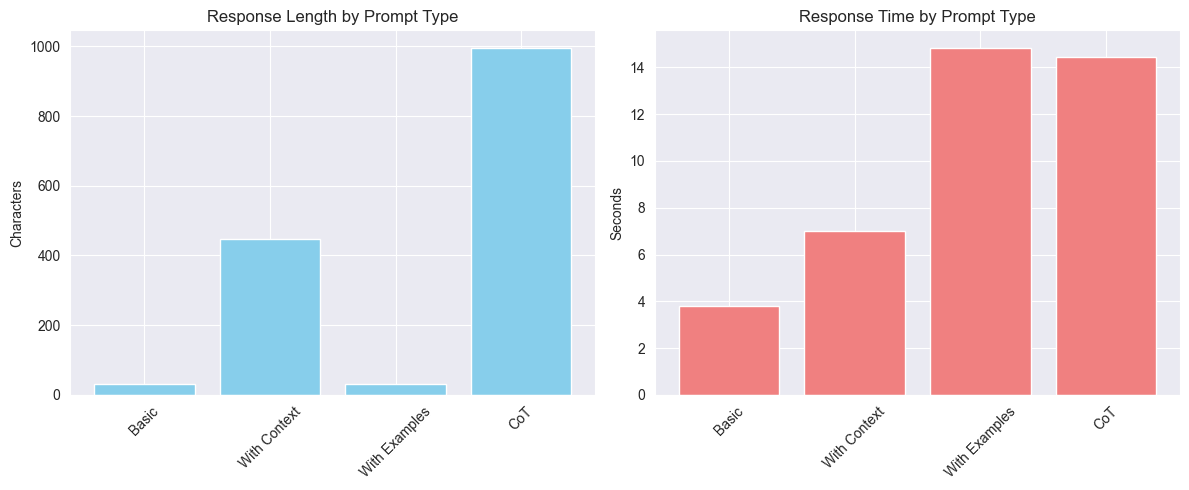

In [24]:
"""
Prompt Performance Visualization: Quantitative Comparison

This example compares different prompt variations across multiple metrics:
1. Response Length: Measures verbosity/detail level
2. Response Time: Measures latency/processing time
3. Response Quality: Can be extended with accuracy metrics

Useful for:
- A/B testing prompt variations
- Optimizing for specific metrics (speed vs. detail)
- Understanding trade-offs between prompt styles
"""

import time

# Define different prompt variations to test
test_prompts = {
    "Basic": "What is the capital of France?",
    "With Context": "Given that Paris is a major European city, what is the capital of France?",
    "With Examples": """What is the capital of France?
Examples:
- Capital of USA: Washington D.C.
- Capital of UK: London
- Capital of France:""",
    "CoT": "What is the capital of France? Think step by step and explain your reasoning."
}

# Store results for each prompt variation
results = []

# Test each prompt variation
for prompt_name, prompt_text in test_prompts.items():
    # Measure response time
    start_time = time.time()
    
    # Generate response
    output = generate_response(
        deepseek_model_client,
        "You are a helpful assistant.",
        prompt_text,
        temperature=0.1
    )
    
    # Calculate elapsed time
    elapsed_time = time.time() - start_time
    
    # Extract final response
    response = output.strip().split("</think>")[-1].strip()
    
    # Store metrics
    results.append({
        "Prompt Type": prompt_name,
        "Response Length": len(response),  # Character count
        "Time (s)": round(elapsed_time, 2),  # Response latency
        "Response": response[:100] + "..." if len(response) > 100 else response  # Preview
    })

# ============================================================================
# Display Results Table
# ============================================================================
results_df = pd.DataFrame(results)
print("=== PROMPT PERFORMANCE COMPARISON ===")
print(results_df.to_string(index=False))

# ============================================================================
# Create Visualizations
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Response Length Comparison
axes[0].bar(results_df["Prompt Type"], results_df["Response Length"], color='skyblue')
axes[0].set_title("Response Length by Prompt Type")
axes[0].set_ylabel("Characters")
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Response Time Comparison
axes[1].bar(results_df["Prompt Type"], results_df["Time (s)"], color='lightcoral')
axes[1].set_title("Response Time by Prompt Type")
axes[1].set_ylabel("Seconds")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
